# Jupyter Notebook: Custom Attention Optimization

Description:
------------
In this notebook, we will:
1. Load a pre-built language model (LLM).
2. Create a copy of the model architecture but replace its attention mechanism with a combination of attention masks.
3. Implement a process to compare the outputs of both models and compute a KL-divergence loss.
4. Optimize the custom model's parameters by minimizing the KL-divergence between the two models’ distributions.
5. Demonstrate how to evaluate and compare both models on sample data.

In [1]:
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn.functional as F

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
)

from transformers import GPT2Config, GPT2LMHeadModel
from transformers.models.gpt2.modeling_gpt2 import GPT2Block

In [4]:
MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
LR = 3e-5
MAX_SEQ_LENGTH = 32
NUM_EPOCHS = 100
SHOW_SAMPLE_OUTPUTS = True
GRAD_CLIP = 1.0

print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
# Pre-built LLM: GPT-2
# Attempt to replicate with a custom attention mechanism

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
reference_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
reference_model.to(DEVICE)
reference_model.eval()  # We will not train this reference model; we only use it for KL-divergence comparisons.

print(f"Reference model '{MODEL_NAME}' loaded successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Reference model 'gpt2' loaded successfully!


In [8]:
## CUSTOM ATTENTION: Linear combination

class OptimizedAttention(nn.Module):
    """
    Attention mechanism that uses pre-computed masks with learnable weights.
    Each position has its own attention mask.
    """
    def __init__(self, config):
        super().__init__()
        self.num_heads = config.n_head
        self.d_model = config.n_embd
        self.head_dim = self.d_model // self.num_heads
        self.max_position = config.n_positions

        # Projection layers
        self.qkv_proj = nn.Linear(self.d_model, 3 * self.d_model)
        self.out_proj = nn.Linear(self.d_model, self.d_model)

        # Create position-specific attention masks
        # Each position gets its own learnable mask
        self.position_masks = nn.Parameter(
            torch.zeros(self.max_position, self.max_position)
        )

        # Optional: Initialize with a reasonable pattern
        # like a sliding window or decaying attention
        with torch.no_grad():
            # Initialize with a decaying pattern
            positions = torch.arange(self.max_position)
            distances = torch.abs(positions.unsqueeze(1) - positions.unsqueeze(0))
            self.position_masks.data = 1.0 / (distances + 1)

        # Add learnable temperature parameter for softmax
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, hidden_states, attention_mask=None):
        batch_size, seq_length, _ = hidden_states.size()

        # Project QKV
        qkv = self.qkv_proj(hidden_states)
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape heads
        q = q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Get relevant portion of position masks
        position_mask = self.position_masks[:seq_length, :seq_length]

        # Scale dot product attention
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)

        # Apply learned position-specific attention pattern
        attn_weights = attn_weights * self.temperature
        attn_weights = attn_weights + position_mask.unsqueeze(0).unsqueeze(0)

        # Apply attention mask if provided
        if attention_mask is not None:
            attn_weights = attn_weights + attention_mask

        # Softmax and dropout
        attn_weights = F.softmax(attn_weights, dim=-1)

        # Apply attention to values
        context = torch.matmul(attn_weights, v)

        # Combine heads
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, seq_length, self.d_model)

        return self.out_proj(context)

class CustomGPT2Block(GPT2Block):
    def __init__(self, config):
        super().__init__(config)
        # Replace attention with our optimized version
        self.attn = OptimizedAttention(config)

    def forward(self, hidden_states, attention_mask=None, **kwargs):
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)

        # Apply optimized attention
        attn_output = self.attn(hidden_states, attention_mask=attention_mask)
        hidden_states = residual + attn_output

        # MLP
        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        return (hidden_states, None, None)  # Match expected return format

def replace_attention_layers(model):
    """Replace attention layers in model with optimized version"""
    config = model.config
    for i, block in enumerate(model.transformer.h):
        model.transformer.h[i] = CustomGPT2Block(config)
    return model

# Initialize model
base_model = GPT2LMHeadModel.from_pretrained("gpt2")
model = replace_attention_layers(base_model)

# Training loop should focus on position_masks
optimizer = torch.optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'position_masks' in n], 'lr': 1e-3},
    {'params': [p for n, p in model.named_parameters() if 'position_masks' not in n], 'lr': 1e-4}
])

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

class WikiTextDataset(Dataset):
    def __init__(self, tokenizer, texts, max_length=512):  # Increased max_length for wiki articles
        super().__init__()
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.texts = [text for text in texts if len(text.strip()) > 100]

        self.encodings = self.tokenizer(
            self.texts,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_ids = self.encodings['input_ids'][idx]
        attention_mask = self.encodings['attention_mask'][idx]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

def create_wikitext_dataloader(tokenizer, batch_size=8, max_length=512):
    real_dataset = load_dataset("wikitext", "wikitext-103-v1")

    train_texts = [txt for txt in real_dataset["train"]["text"]
                  if len(txt) > 100][:100]

    dataset = WikiTextDataset(
        tokenizer=tokenizer,
        texts=train_texts,
        max_length=max_length
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    return dataloader


tokenizer.pad_token = tokenizer.eos_token
train_dataloader = create_wikitext_dataloader(
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE
)

In [15]:
########################################
# Cell 6: KL-Divergence Loss Setup
########################################

# We define a function that calculates the KL-divergence between the output distributions
# of the reference model and the custom model.
# Typically, for language modeling, we get the logits from each model and then apply
# a cross-entropy or KL divergence measure on the probability distributions.

def kl_divergence_loss(logits_custom, logits_ref, mask):
    """Numerically stable KL divergence with masking"""
    assert logits_custom.shape == logits_ref.shape, \
        f"Shape mismatch: {logits_custom.shape} vs {logits_ref.shape}"

    log_probs_custom = F.log_softmax(logits_custom, dim=-1)
    probs_ref = F.softmax(logits_ref.detach(), dim=-1)  # Detach reference model

    kl_div = F.kl_div(
        log_probs_custom,
        probs_ref,
        reduction='none'
    ).sum(dim=-1)

    # Apply attention mask
    if mask is not None:
        kl_div = kl_div * mask

    # Average over non-masked positions
    loss = kl_div.sum() / mask.sum()

    return loss

In [20]:
########################################
# Cell 7: Training Loop for Custom Model
########################################

# We will train the custom model for a few epochs to minimize KL-divergence from the reference model.

model.to(DEVICE)
model.train()

for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        with torch.no_grad():
            outputs_ref = reference_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits_ref = outputs_ref.logits

        outputs_custom = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits_custom = outputs_custom.logits

        loss = kl_divergence_loss(logits_custom, logits_ref, attention_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Avg KL-div Loss: {avg_loss:.4f}")

Epoch [1/100], Avg KL-div Loss: 2.0807
Epoch [2/100], Avg KL-div Loss: 1.8796
Epoch [3/100], Avg KL-div Loss: 1.6670
Epoch [4/100], Avg KL-div Loss: 1.5453
Epoch [5/100], Avg KL-div Loss: 1.4293
Epoch [6/100], Avg KL-div Loss: 1.3672
Epoch [7/100], Avg KL-div Loss: 1.2592
Epoch [8/100], Avg KL-div Loss: 1.1514
Epoch [9/100], Avg KL-div Loss: 1.0713
Epoch [10/100], Avg KL-div Loss: 1.0037
Epoch [11/100], Avg KL-div Loss: 0.9795
Epoch [12/100], Avg KL-div Loss: 0.9426
Epoch [13/100], Avg KL-div Loss: 0.8841
Epoch [14/100], Avg KL-div Loss: 0.8524
Epoch [15/100], Avg KL-div Loss: 0.8147
Epoch [16/100], Avg KL-div Loss: 0.7669
Epoch [17/100], Avg KL-div Loss: 0.7295
Epoch [18/100], Avg KL-div Loss: 0.6910
Epoch [19/100], Avg KL-div Loss: 0.6907
Epoch [20/100], Avg KL-div Loss: 0.6584
Epoch [21/100], Avg KL-div Loss: 0.6140
Epoch [22/100], Avg KL-div Loss: 0.6144
Epoch [23/100], Avg KL-div Loss: 0.5954
Epoch [24/100], Avg KL-div Loss: 0.5752
Epoch [25/100], Avg KL-div Loss: 0.5452
Epoch [26

In [21]:
########################################
# Cell 8: Comparison/Testing
########################################

# We can now compare the outputs of the reference model vs. the custom model on some sample prompts.
# For demonstration, we’ll do a simple generation from each.

def generate_text(model, prompt, temperature=0.7, top_k=50, max_length=50):
    """Improved generation with sampling and length normalization"""
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.2,
        no_repeat_ngram_size=2,
        use_cache=False  # Explicitly disable caching
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

if SHOW_SAMPLE_OUTPUTS:
    sample_prompts = [
        "Hello, my name is",
        "The meaning of life is",
        "In a shocking turn of events,",
        "The future of artificial intelligence"
    ]

    for prompt in sample_prompts:
        # Generate with different parameters for comparison
        ref_text = generate_text(reference_model, prompt, temperature=0.9)
        custom_text = generate_text(model, prompt, temperature=0.8)

        print(f"\nPrompt: {prompt}")
        print(f"Reference: {ref_text}")
        print(f"Custom:    {custom_text}")
        print("-" * 80)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Prompt: Hello, my name is
Reference: Hello, my name is Aaron and I'm a freelance writer who writes for Wired.com about tech news (and also an early contributor to TechCrunch). So what was it like being interviewed by the Washington Post in 2010?
First of all,
Custom:    Hello, my name is a very very all in which I am on the right are in and were not for the most of the production. " but as when they've to their own and military equipment used in a field of some--22.
--------------------------------------------------------------------------------

Prompt: The meaning of life is
Reference: The meaning of life is all one man has. He who conquers the world will not die, and we shall live according to our Will until a new creation comes into existence." "O what an error ! O foolish gods! if they kill you
Custom:    The meaning of life is not yet been used to a high, the same level and the children. . They should not have an up , a long, (5 in which will have not at this time, their own or 

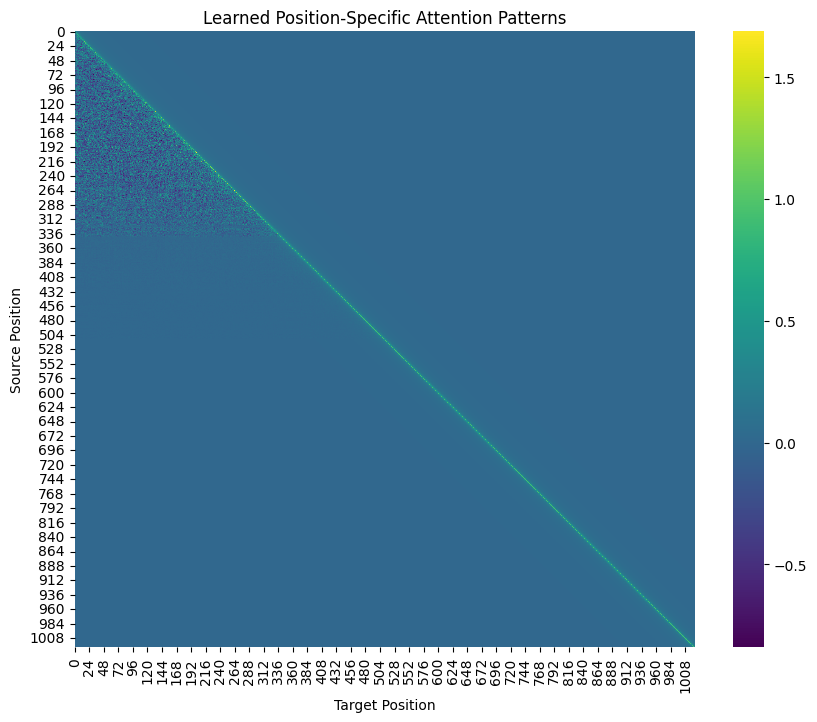

Max value: 1.6887604
Min value: -0.8420545
Mean value: 0.010448952
Sparsity (% of near-zero values): 77.94771194458008


In [28]:
position_masks = model.transformer.h[10].attn.position_masks.detach().cpu()

# Convert to numpy for easier visualization if needed
position_masks_np = position_masks.numpy()

# Basic visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(position_masks_np, cmap='viridis')
plt.title('Learned Position-Specific Attention Patterns')
plt.xlabel('Target Position')
plt.ylabel('Source Position')
plt.show()

# You can also print statistics about the masks
print("Max value:", position_masks_np.max())
print("Min value:", position_masks_np.min())
print("Mean value:", position_masks_np.mean())
print("Sparsity (% of near-zero values):",
      (np.abs(position_masks_np) < 0.01).mean() * 100)

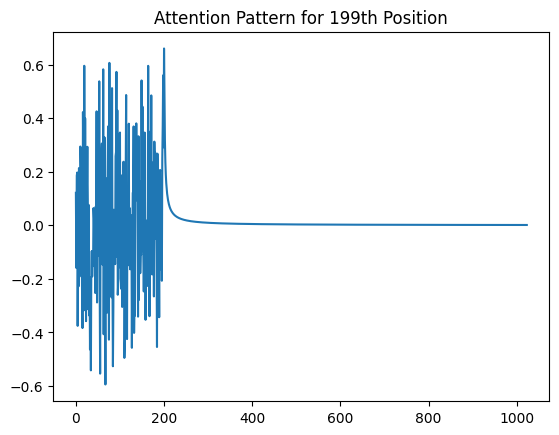

In [36]:
# Look at attention pattern for position 199
plt.plot(position_masks_np[200])
plt.title('Attention Pattern for 199th Position')
plt.show()

In [37]:
position_masks_np[200]

array([ 0.1210953 , -0.15924676,  0.18523052, ...,  0.00114729,
        0.0011459 ,  0.00114451], dtype=float32)